In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from collections import Counter
import itertools

# Importaciones para los gráficos de red interactivos
import plotly.graph_objects as go
from sklearn.preprocessing import minmax_scale

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Carga del dataset de YouTube
try:
    df = pd.read_csv(Path('../data/youtube_videos_final.csv'))
    print("CSV file loaded successfully!")
except FileNotFoundError:
    print("Warning: File not found at '../data/'. Trying local path './youtube_videos_final.csv'...")
    try:
        df = pd.read_csv(Path('./youtube_videos_final.csv'))
        print("CSV file loaded successfully from local path!")
    except FileNotFoundError:
        print(f"Error: File not found at {Path('./data/youtube_videos_final.csv').resolve()} or local path.")
        df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred: {e}")
    df = pd.DataFrame()

if not df.empty:
    print("\nData Head:")
    print(df.head())
    print("\nData Info:")
    df.info()
else:
    print("DataFrame is empty. Cannot proceed with analysis.")

CSV file loaded successfully!

Data Head:
      video_id country trending_date  \
0  n1WpP7iowLc      CA      17.14.11   
1  0dBIkQ4Mz1M      CA      17.14.11   
2  5qpjK5DgCt4      CA      17.14.11   
3  d380meD0W0M      CA      17.14.11   
4  2Vv-BfVoq4g      CA      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id  category_name              publish_time  \
0           10          Music  2017-11-10T17:00:03.000Z   
1           23         Comedy  2017-11-13T17:00:00.000Z   
2           23         Comedy  2017-11-12T19:05:24.000Z   
3           24  Entertainment  2017-11-12T18:01:41.000Z   
4

In [3]:
# ============================================================================
# STEP 1 & 2: LOAD/PREPARE DATA & BUILD NETWORK
# Logic: Nodes = Channels, Edges = Shared Categories
# ============================================================================

if not df.empty:
    # 1. Aggregate by channel to get attributes
    df_nodes = df.groupby('channel_title').agg(
        categories=('category_name', 'unique'),
        total_views=('views', 'sum'),
        total_likes=('likes', 'sum'),
        avg_likes_per_view=('likes', lambda x: x.sum() / df.loc[x.index, 'views'].sum() if df.loc[x.index, 'views'].sum() > 0 else 0)
    ).reset_index()

    # Filter for a manageable graph (Top 500 channels by views)
    df_nodes = df_nodes.nlargest(500, 'total_views').copy()
    
    print(f"Total nodes (channels) for network: {len(df_nodes)}")

    # 2. Create the network
    G = nx.Graph()

    # Add nodes (Channels) with attributes
    for idx, row in df_nodes.iterrows():
        G.add_node(
            row['channel_title'],
            categories=row['categories'],
            views=row['total_views'],
            likes=row['total_likes'],
            rating_metric=row['avg_likes_per_view'] # Using this as "rating"
        )

    # 3. Add edges (connections)
    print("\nBuilding edges (based on shared categories)...")
    node_list = list(df_nodes.itertuples(index=False))

    for i, channel1 in enumerate(node_list):
        for channel2 in node_list[i+1:]:
            # Check for shared categories
            shared_categories = set(channel1.categories) & set(channel2.categories)
            if shared_categories:
                # Weight is the number of shared categories
                G.add_edge(channel1.channel_title, channel2.channel_title, weight=len(shared_categories))

    print(f"\nNetwork Statistics (Full Graph):")
    print(f"Nodes (channels): {G.number_of_nodes()}")
    print(f"Edges (connections): {G.number_of_edges()}")
    
    # 4. Analyze the largest connected component
    if not nx.is_connected(G):
        print("Network is disconnected. Analyzing largest connected component.")
        largest_cc_nodes = max(nx.connected_components(G), key=len)
        G_main = G.subgraph(largest_cc_nodes).copy()
        print(f"Largest component has {G_main.number_of_nodes()} nodes and {G_main.number_of_edges()} edges.")
    else:
        print("Network is connected.")
        G_main = G
else:
    print("Cannot build network, DataFrame is empty.")

Total nodes (channels) for network: 500

Building edges (based on shared categories)...

Network Statistics (Full Graph):
Nodes (channels): 500
Edges (connections): 36746
Network is connected.


In [4]:
# ============================================================================
# STEP 3: CALCULATE CENTRALITY METRICS (on G_main)
# ============================================================================

if 'G_main' in locals():
    print("\nCalculating centrality metrics...")

    # 1. Degree Centrality
    degree_centrality = nx.degree_centrality(G_main)

    # 2. Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G_main)

    # 3. Betweenness Centrality (with 'k' sampling for efficiency)
    betweenness_centrality = nx.betweenness_centrality(G_main, k=min(100, G_main.number_of_nodes()), seed=42)

    # 4. PageRank
    pagerank = nx.pagerank(G_main)

    print("Centrality calculations complete!")
else:
    print("G_main not defined. Skipping centrality calculation.")


Calculating centrality metrics...
Centrality calculations complete!


In [5]:
# ============================================================================
# STEP 4: CREATE COMPARISON DATAFRAME
# ============================================================================

if 'degree_centrality' in locals():
    centrality_df = pd.DataFrame({
        'channel_title': list(degree_centrality.keys()),
        'degree_centrality': list(degree_centrality.values()),
        'closeness_centrality': list(closeness_centrality.values()),
        'betweenness_centrality': list(betweenness_centrality.values()),
        'pagerank': list(pagerank.values())
    })

    # Add channel info (our "rating" and "popularity" attributes)
    centrality_df['rating'] = centrality_df['channel_title'].apply(lambda x: G_main.nodes[x]['rating_metric'])
    centrality_df['views'] = centrality_df['channel_title'].apply(lambda x: G_main.nodes[x]['views'])
    centrality_df['likes'] = centrality_df['channel_title'].apply(lambda x: G_main.nodes[x]['likes'])

    # Calculate composite score (normalized)
    for col in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'pagerank']:
        centrality_df[f'{col}_norm'] = minmax_scale(centrality_df[col])

    centrality_df['composite_score'] = centrality_df[[
        'degree_centrality_norm', 
        'closeness_centrality_norm', 
        'betweenness_centrality_norm', 
        'pagerank_norm'
    ]].mean(axis=1)

    # Sort by composite score
    centrality_df = centrality_df.sort_values('composite_score', ascending=False)

    print("\n" + "="*80)
    print("TOP 10 MOST CENTRAL CHANNELS (by composite score)")
    print("="*80)
    display_cols = ['channel_title', 'degree_centrality', 'closeness_centrality', 
                    'betweenness_centrality', 'pagerank', 'rating', 'views']
    print(centrality_df[display_cols].head(10).to_string(index=False))
else:
    print("Centrality metrics not calculated. Skipping DataFrame creation.")


TOP 10 MOST CENTRAL CHANNELS (by composite score)
    channel_title  degree_centrality  closeness_centrality  betweenness_centrality  pagerank   rating      views
        PewDiePie           0.869739              0.884752                0.093962  0.007430 0.071453 2922023707
Jimmy Kimmel Live           0.759519              0.806139                0.043883  0.005110 0.020025 1257747286
            Vogue           0.763527              0.808752                0.036235  0.005308 0.058930  410331490
       Marshmello           0.753507              0.802251                0.038222  0.005206 0.038333 1416817188
               GQ           0.741483              0.794586                0.030468  0.004998 0.031244  331066571
      BBC Radio 1           0.747495              0.798400                0.030562  0.004833 0.036951  340819904
Wunderbar Studios           0.747495              0.798400                0.030562  0.004833 0.030629  425086629
       marshmello           0.725451         

In [6]:
# ============================================================================
# STEP 5: STATISTICAL SUMMARY
# ============================================================================
if 'centrality_df' in locals():
    print("\n" + "="*80)
    print("CENTRALITY METRICS STATISTICAL SUMMARY")
    print("="*80)
    summary_stats = centrality_df[['degree_centrality', 'closeness_centrality', 
                                    'betweenness_centrality', 'pagerank']].describe()
    print(summary_stats)
else:
    print("centrality_df not available. Skipping summary.")


CENTRALITY METRICS STATISTICAL SUMMARY
       degree_centrality  closeness_centrality  betweenness_centrality  \
count         500.000000            500.000000              500.000000   
mean            0.294557              0.575703                0.001551   
std             0.176737              0.069115                0.007054   
min             0.010020              0.415833                0.000000   
25%             0.076152              0.519792                0.000000   
50%             0.292585              0.585682                0.000000   
75%             0.438878              0.616811                0.000000   
max             0.869739              0.884752                0.093962   

         pagerank  
count  500.000000  
mean     0.002000  
std      0.000810  
min      0.000509  
25%      0.001312  
50%      0.002240  
75%      0.002240  
max      0.007430  


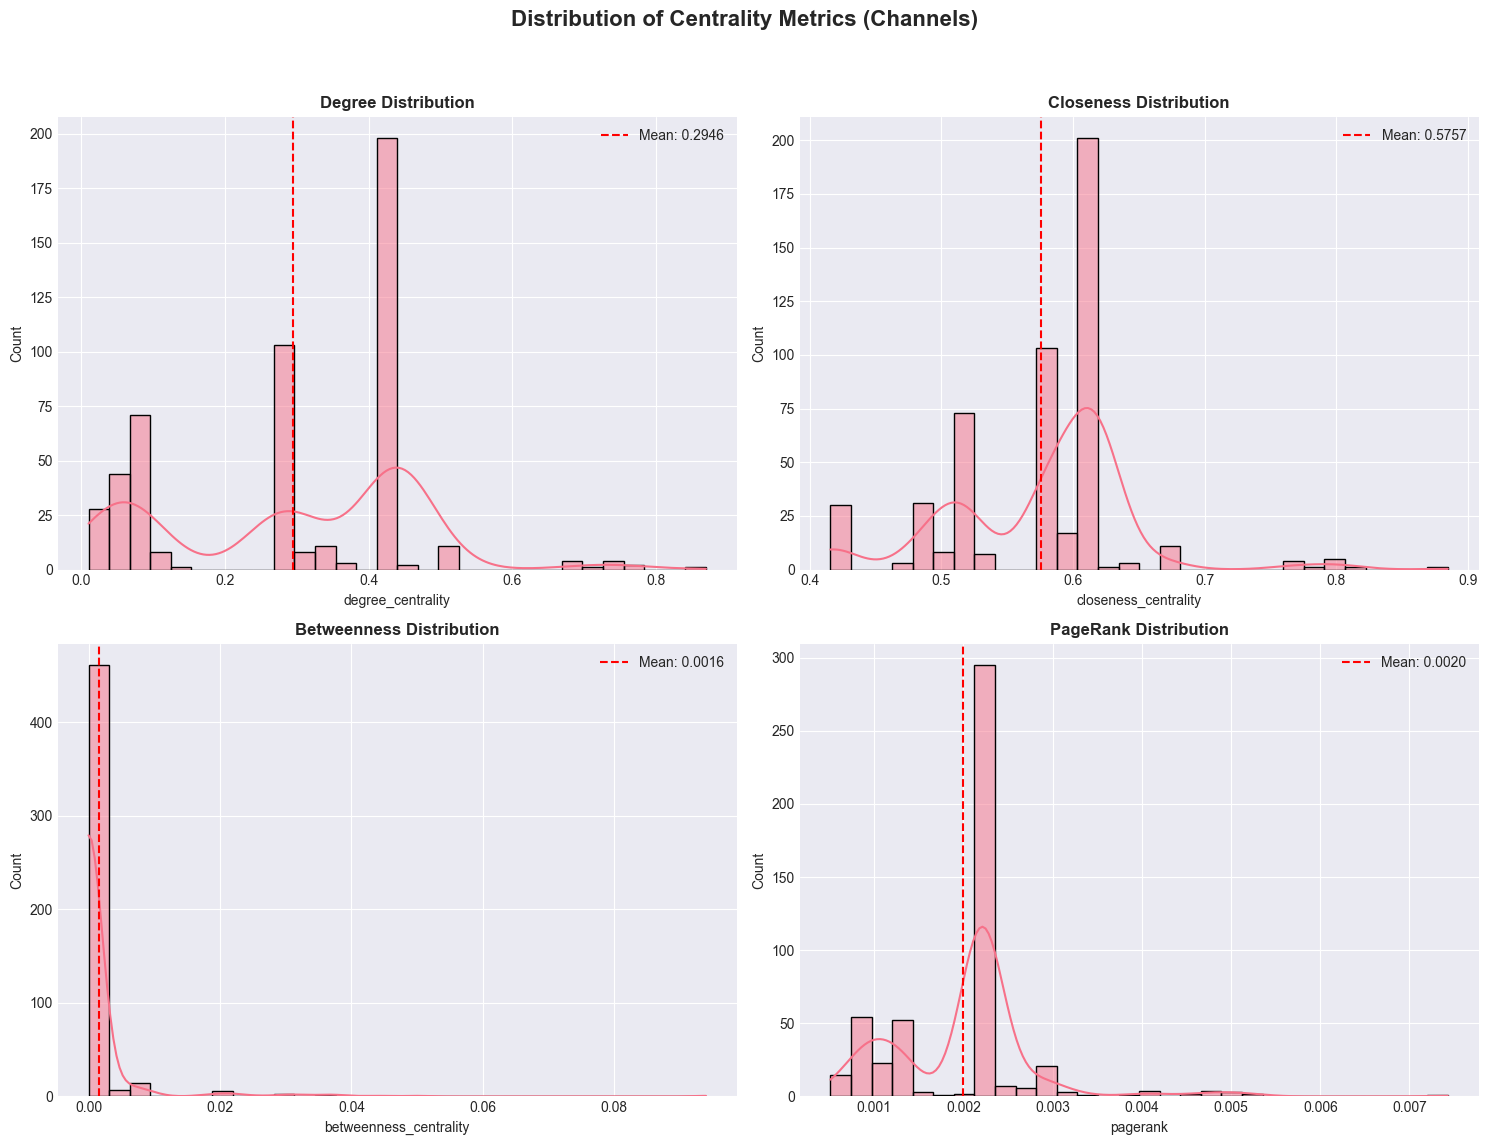

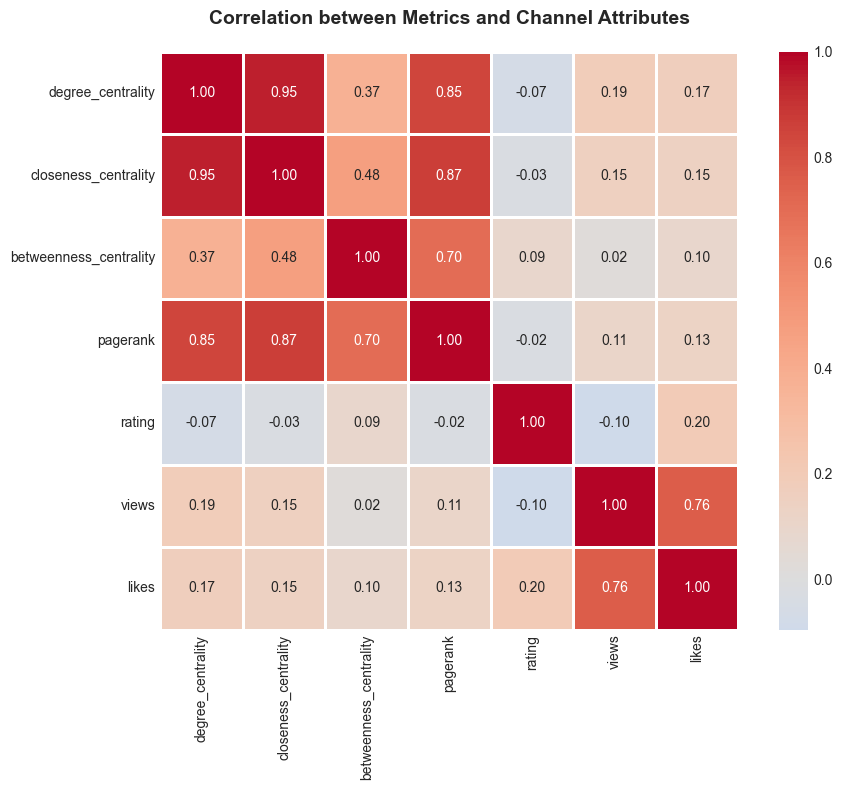

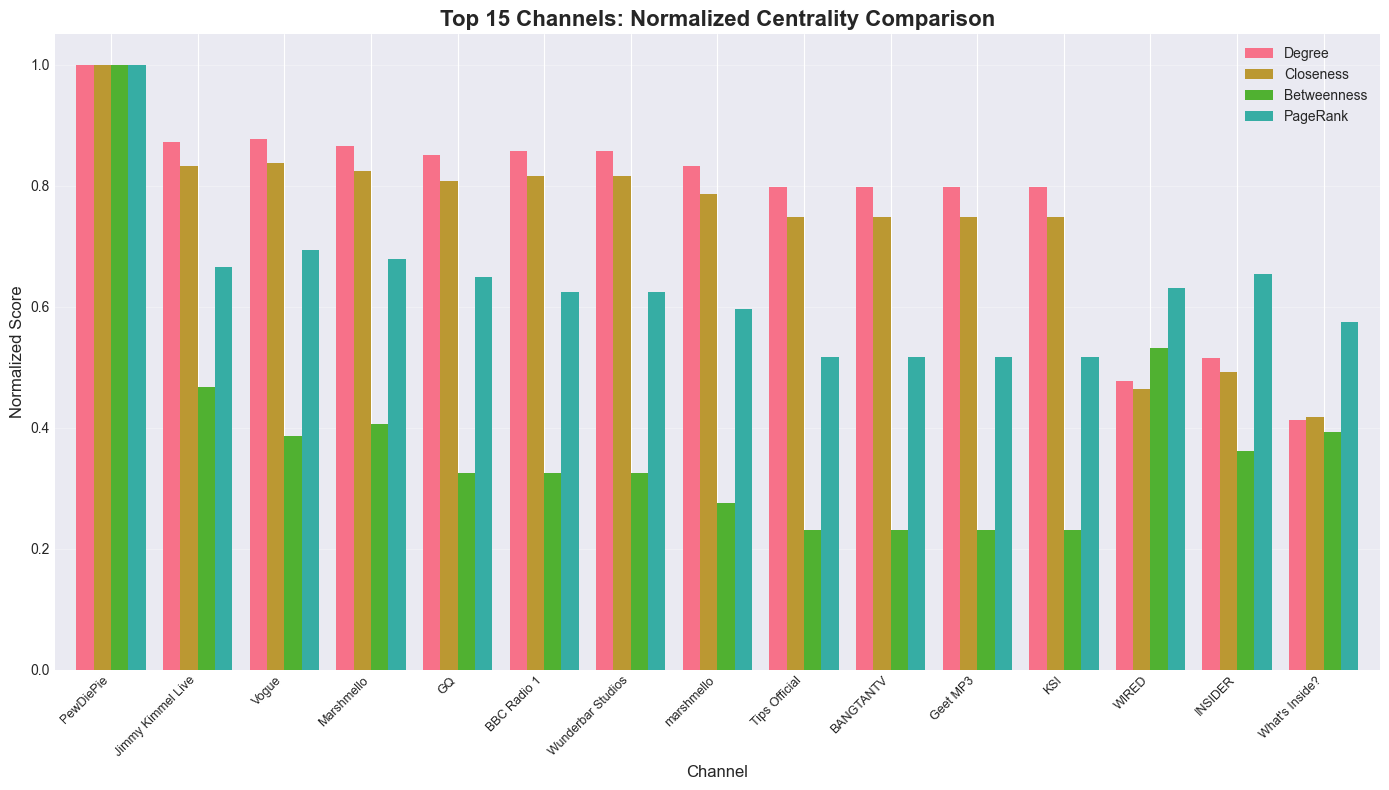

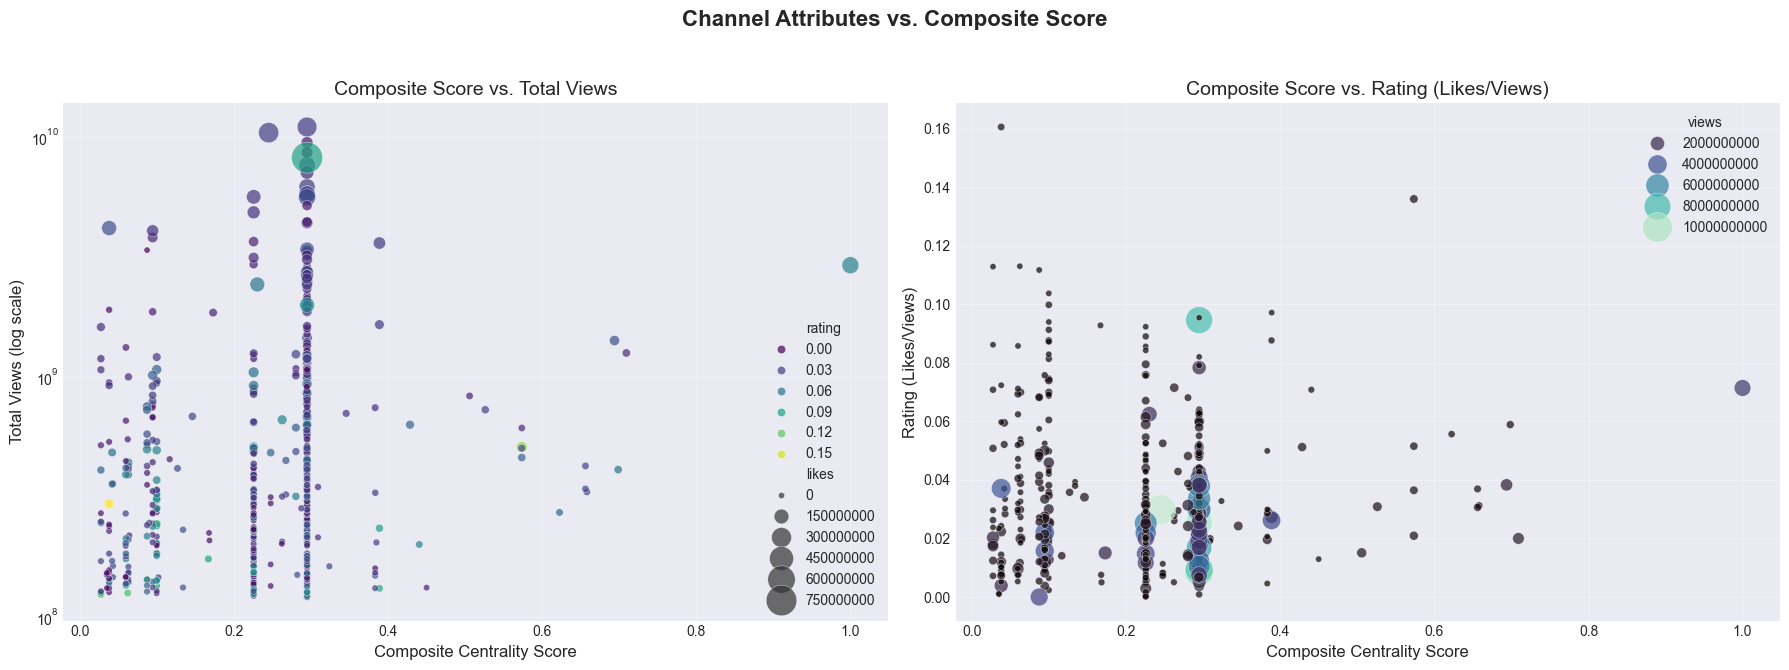


Analysis plots generated successfully.


In [7]:
# ============================================================================
# STEP 6: ANALYSIS VISUALIZATIONS (Replicated & Translated)
# ============================================================================

if 'centrality_df' in locals():
    
    # --- Visualization 1: Distribution of Metrics ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Distribution of Centrality Metrics (Channels)', fontsize=16, fontweight='bold')
    metrics = ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'pagerank']
    titles = ['Degree', 'Closeness', 'Betweenness', 'PageRank']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        sns.histplot(centrality_df[metric], bins=30, ax=ax, kde=True)
        ax.set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
        ax.axvline(centrality_df[metric].mean(), color='red', linestyle='--', 
                   label=f'Mean: {centrality_df[metric].mean():.4f}')
        ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Muestra el gráfico

    # --- Visualization 2: Correlation Heatmap ---
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_metrics = metrics + ['rating', 'views', 'likes']
    correlation_matrix = centrality_df[corr_metrics].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, ax=ax)
    ax.set_title('Correlation between Metrics and Channel Attributes', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show() # Muestra el gráfico

    # --- Visualization 3: Top Channels Comparison ---
    top_n = 15
    top_channels_viz = centrality_df.head(top_n)
    
    viz_cols = ['degree_centrality_norm', 'closeness_centrality_norm', 
                'betweenness_centrality_norm', 'pagerank_norm']
    
    ax = top_channels_viz.plot(
        x='channel_title', 
        y=viz_cols, 
        kind='bar', 
        figsize=(14, 8),
        width=0.8
    )
    ax.set_title(f'Top {top_n} Channels: Normalized Centrality Comparison', fontsize=16, fontweight='bold')
    ax.set_ylabel('Normalized Score', fontsize=12)
    ax.set_xlabel('Channel', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.legend(titles, loc='upper right')
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show() # Muestra el gráfico

    # --- Visualization 4: Scatter Plots - Views/Rating vs Centrality ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Channel Attributes vs. Composite Score', fontsize=16, fontweight='bold')

    # Views vs Score
    sns.scatterplot(
        data=centrality_df, 
        x='composite_score', 
        y='views', 
        size='likes', 
        hue='rating', 
        palette='viridis', 
        sizes=(20, 500), 
        alpha=0.7, 
        ax=axes[0]
    )
    axes[0].set_title('Composite Score vs. Total Views', fontsize=14)
    axes[0].set_ylabel('Total Views (log scale)', fontsize=12)
    axes[0].set_xlabel('Composite Centrality Score', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)

    # Rating vs Score
    sns.scatterplot(
        data=centrality_df, 
        x='composite_score', 
        y='rating', 
        size='views', 
        hue='views', 
        palette='mako', 
        sizes=(20, 500), 
        alpha=0.7, 
        ax=axes[1]
    )
    axes[1].set_title('Composite Score vs. Rating (Likes/Views)', fontsize=14)
    axes[1].set_ylabel('Rating (Likes/Views)', fontsize=12)
    axes[1].set_xlabel('Composite Centrality Score', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Muestra el gráfico
    
    print("\nAnalysis plots generated successfully.")
else:
    print("centrality_df not available. Skipping analysis plots.")

In [ ]:
# ============================================================================
# NETWORK GRAPH 1: CHANNEL NETWORK (Nodes=Channel, Links=Categories)
# ============================================================================

if 'G_main' in locals():
    print("\nGenerating interactive network graph (Channel Network)...")
    
    # 1. Get positions
    pos = nx.spring_layout(G_main, k=0.3, iterations=50, seed=42)

    # 2. Edge Trace
    edge_x = []
    edge_y = []
    for edge in G_main.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # 3. Node Trace
    node_x = []
    node_y = []
    node_text = []
    node_sizes = []
    node_colors = []

    for node in G_main.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        views = G_main.nodes[node].get('views', 0)
        rating = G_main.nodes[node].get('rating_metric', 0)
        node_sizes.append(views)
        node_colors.append(rating)
        node_text.append(
            f"<b>{node}</b><br>"
            f"Total Views: {views:,.0f}<br>"
            f"Rating (Likes/View): {rating:.4f}<br>"
            f"Degree: {degree_centrality.get(node, 0):.3f}"
        )

    # Scale node sizes for better visibility (log)
    scaled_node_size = [np.log10(size + 1) * 5 for size in node_sizes]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=node_colors,
            size=scaled_node_size,
            colorbar=dict(
                thickness=15,
                title=dict(text='Channel Rating (Likes/View)', side='right'), # <-- CORRECCIÓN
                xanchor='left'
            ),
            line_width=1,       
            line_color='#333'   
        )
    )

    # 4. Render
    fig_net1 = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=dict(
                        text='<br>Channel Network (Top 500 by Views)', # <-- CORRECCIÓN
                        font=dict(size=16)                             # <-- CORRECCIÓN
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='#f4f4f4'
                    )
                )
    
    fig_net1.show() # Muestra el gráfico
else:
    print("G_main not defined. Skipping network graph 1.")


Generating interactive network graph (Channel Network)...


In [11]:
# ============================================================================
# NETWORK GRAPH 2: BIPARTITE NETWORK (Channel-Category)
# ============================================================================

if not df.empty:
    print("\nGenerating interactive network graph (Bipartite Network)...")
    
    # 1. Prepare Data
    df_channel_cat = df.groupby(['channel_title', 'category_name'])['views'].sum().reset_index()

    # Filter to Top 50 Channels and Top 15 Categories for clarity
    top_channels_b = df.groupby('channel_title')['views'].sum().nlargest(50).index
    top_categories_b = df.groupby('category_name')['views'].sum().nlargest(15).index

    df_filtered = df_channel_cat[
        df_channel_cat['channel_title'].isin(top_channels_b) & 
        df_channel_cat['category_name'].isin(top_categories_b)
    ]

    channel_views = df.groupby('channel_title')['views'].sum().to_dict()
    category_views = df.groupby('category_name')['views'].sum().to_dict()

    # 2. Create Bipartite Graph
    B = nx.Graph()
    
    # Add nodes
    for channel in df_filtered['channel_title'].unique():
        B.add_node(channel, type='channel', views=channel_views.get(channel, 0))
    for category in df_filtered['category_name'].unique():
        B.add_node(category, type='category', views=category_views.get(category, 0))
    
    # Add edges
    for _, row in df_filtered.iterrows():
        B.add_edge(row['channel_title'], row['category_name'], weight=row['views'])

    # 3. Bipartite Layout
    pos = {}
    channel_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'channel']
    category_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'category']
    
    pos.update((node, (1, i)) for i, node in enumerate(channel_nodes))
    pos.update((node, (2, i * (len(channel_nodes) / len(category_nodes)))) for i, node in enumerate(category_nodes))

    # 4. Edge Traces
    edge_x, edge_y, edge_weights = [], [], []
    for u, v, data in B.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(data['weight'])

    scaled_edge_alpha = minmax_scale(edge_weights, (0.1, 0.7))
    
    edge_traces = []
    for i, edge in enumerate(B.edges()):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = B.edges[edge]['weight']
        alpha = scaled_edge_alpha[i]
        edge_traces.append(
            go.Scatter(
                x=[x0, x1, None], y=[y0, y1, None],
                line=dict(width=1.5, color=f'rgba(50, 50, 50, {alpha})'),
                hoverinfo='text', text=f"Views: {weight:,.0f}", mode='lines'
            )
        )

    # 5. Node Traces
    node_x_ch, node_y_ch, node_text_ch, node_size_ch = [], [], [], []
    node_x_cat, node_y_cat, node_text_cat, node_size_cat = [], [], [], []

    for node, data in B.nodes(data=True):
        x, y = pos[node]
        views = data['views']
        text = f"<b>{node}</b><br>Total Views: {views:,.0f}"
        if data['type'] == 'channel':
            node_x_ch.append(x)
            node_y_ch.append(y)
            node_text_ch.append(text)
            node_size_ch.append(views)
        else:
            node_x_cat.append(x)
            node_y_cat.append(y)
            node_text_cat.append(text)
            node_size_cat.append(views)

    scaled_size_ch = minmax_scale(node_size_ch, (10, 40))
    scaled_size_cat = minmax_scale(node_size_cat, (10, 40))

    trace_channels = go.Scatter(
        x=node_x_ch, y=node_y_ch, mode='markers',
        hoverinfo='text', text=node_text_ch,
        marker=dict(
            size=scaled_size_ch, color='#0077b6', 
            line_width=1, line_color='#333'  
        ),
        name='Channel'
    )
    trace_categories = go.Scatter(
        x=node_x_cat, y=node_y_cat, mode='markers',
        hoverinfo='text', text=node_text_cat,
        marker=dict(
            size=scaled_size_cat, color='#d9534f', 
            line_width=1, line_color='#333'  
        ),
        name='Category'
    )

    # 6. Render
    fig_net2 = go.Figure(data=edge_traces + [trace_channels, trace_categories],
                  layout=go.Layout(
                    title=dict(
                        text='<br>Bipartite Network: Channel-Category Connections', # <-- CORRECCIÓN
                        font=dict(size=16)                                        # <-- CORRECCIÓN
                    ), 
                    showlegend=True, 
                    legend_title_text='Node Type',
                    hovermode='closest',
                    margin=dict(b=5, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='white', paper_bgcolor='#f9f9f9'
                ))

    fig_net2.show() # Muestra el gráfico
else:
    print("DataFrame empty. Skipping bipartite network.")


Generating interactive network graph (Bipartite Network)...
